# Team_A : XEntropistes - code source

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_validate,KFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve, auc


# Load Data

In [2]:
def load_Cookies_80():
    return pd.read_csv("COOKIES_80.csv")
def load_Subsribers_80():
    return pd.read_csv("SUBSCRIBERS_80.csv")
def load_Cookies_20():
    return pd.read_csv("COOKIES_20.csv")

# Merge features and target 

In [3]:
def merge_features_data(coockies,subscribers):
    subscribed = coockies.merge(subscribers, on='identifiant')
    non_subscribed=coockies[~coockies['identifiant'].isin(subscribers['identifiant'])]
    subscribed['TARGET']=1
    non_subscribed['TARGET']=0
    coockies=pd.concat([subscribed,non_subscribed], ignore_index=True)
    return coockies

# Rubrique Processing
* process_rubrique() : retourne le nombre de reubriques consultées par utilisateur
* rubrique() : classer les rubrique en 3 : rubrique fréquentes, moyenne et minimale :selon le nombre de rubriques consultées par utilisateur

In [4]:
def process_rubrique(cookies):
    cookies.rubrique.fillna("x",inplace =True)
    rubrique_id = cookies[['identifiant','rubrique']].groupby('identifiant').agg(['count'])
    return rubrique_id

def rubrique(cookies):
    periode = []
    mean =cookies[cookies.columns[1]].mean()
    median=cookies[cookies.columns[1]].median()
    for x in cookies[cookies.columns[1]]:
        if (x >= mean):
            periode.append("rub_fq")
        elif (x >= median and x < mean):
            periode.append("rub_moy")
        else :
            periode.append("rub_min")
    cookies["RUB"] = periode 

# Concat by Identifiant two datasets
* concat_by_identifiant() : retourn une dataset concatenée par l'identifiant
* get_unique_identifiant() : retourn les identifiants uniques

In [5]:
def concat_by_identifiat(dataset1,dataset2):
    dataset=pd.merge(dataset1, dataset2, left_index=True, right_index=True, how='outer')
    return dataset

In [6]:
def get_unique_identifiant(cookies,dataset_to_predict=False):
    if(dataset_to_predict!=True): 
        target_identifiant = cookies[['identifiant','TARGET']].drop_duplicates(["identifiant"])
    else : 
        target_identifiant = cookies[['identifiant']].drop_duplicates(["identifiant"])
        
    target_identifiant.set_index('identifiant', inplace=True)
    return target_identifiant

# Get Time by page
* get_mean_time_by_page() : retourn la durée moyenne passée par chaque utilisateurs dans chaque page 

In [7]:
def get_mean_time_by_page(cookies):
    cookies['duree_visite_moyenne'] = cookies['temps_page'].groupby(cookies['identifiant']).transform('mean')
    df_DUREE = cookies[["duree_visite_moyenne","identifiant"]].drop_duplicates(["identifiant"])
    df_DUREE.set_index('identifiant', inplace=True)
    return df_DUREE

# Date heure visite processing

In [8]:
def split_houre_date_(cookies):
    date_visite = []
    heure_visite = []

    for x in cookies["date_heure_visite"]:
        date_visite.append(int(x[0]+x[1]))
        x_split = x.split(":")
        heure_visite.append(int(x_split[1]+x_split[2]+x_split[3]))
    
    cookies["heure_visite"] = heure_visite
    cookies["date_visite"] = date_visite
    return cookies

* periode() :  dévise les heures de visite à des périodes afin de détecter par la suite la période la plus fréquente de visite du site 

In [9]:
def periode(cookies):
    periode = []
    for x in cookies["heure_visite"]:
        if (x >=80000 and x<120000):
            periode.append("MATIN")
        elif (x >=120000 and x<180000):
            periode.append("MIDI")
        elif (x >=180000) :
            periode.append("SOIR")
        else:
            periode.append("NUIT")   
    return periode 

In [10]:
def period_count(cookies):
    df_periode_id = cookies[['identifiant','PERIODE']].groupby('identifiant').agg(['count'])
    return df_periode_id

* duree() :  retourne la durée maximale et minimale de chaque utilisateur

In [11]:
def duree(cookies):
    periode = []
    mean = cookies.duree_visite_moyenne.mean()
    for x in cookies["duree_visite_moyenne"]:
        if (x >= mean):
            periode.append("duree_max")
        else:
            periode.append("duree_min")
    cookies["DUREE_VISITE"] = periode 

* duree() :  retourne si l'utilisateur à visiter le site la dernière semaine ou non 

In [12]:
def last(cookies):
    periode = []
    mean = 24
    for x in cookies["dernier_jour"]:
        if (x >= mean):
            periode.append("last_week")
        else:
            periode.append("no_last_week")
    cookies["LAST_WEEK"] = periode 

#   number visite   feature
* get_Nbr_visite() : retourne le nombre de visite par chaque utilisateurs
* get_Nbr_visite_day() : retourne le nombre de visite par jour
* last_week_visit() : retourne le dernier jour où l'utilisateur à visiter le site
* visite() : retourne une classification des visite à des visites fréquentes, moyennes ou minimales selon le nombre de visite par utilisat
* jour_visite() : retourne une classification des visites régulières à des visites par jour fréquentes, moyennes ou minimales selon le nombre de visite par utilisat

In [13]:
def get_Nbr_visite(cookies):
    cookies["visite_totale"] =cookies['id_visite'].groupby(cookies['identifiant']).transform('count')
    df_NBR_VISITE =  cookies[["visite_totale","identifiant"]]
    df_NBR_VISITE.drop_duplicates(["identifiant"],inplace = True)
    df_NBR_VISITE.set_index('identifiant', inplace=True)
    return df_NBR_VISITE

def get_Nbr_visite_day(cookies):
    cookies = split_houre_date_(cookies)
    a =cookies.groupby(['date_visite','identifiant']).size().reset_index().groupby('identifiant')[[0]].mean()
    a.columns = ['avg_visite_jour']
    return a

def last_week_visit(cookies):
    cookies = split_houre_date_(cookies)
    a =cookies[['identifiant','date_visite']].groupby('identifiant').agg(['max'])
    a.columns = ['dernier_jour']
    return a

def visite(cookies):
    periode = []
    mean = cookies.visite_totale.mean()
    median = cookies.visite_totale.median()
    for x in cookies["visite_totale"]:
        if (x >= mean):
            periode.append("visite_fq")
        elif (x >= median and x < mean):
            periode.append("visite_moy")
        else :
            periode.append("visite_rare")
    cookies["VISITE"] = periode 
    
def jour_visite(cookies):
    periode = []
    mean = cookies.avg_visite_jour.mean()
    median = cookies.avg_visite_jour.median()
    for x in cookies["avg_visite_jour"]:
        if (x >= mean):
            periode.append("jvisite_fq")
        elif (x >= median and x < mean):
            periode.append("jvisite_moy")
        else :
            periode.append("jvisite_rare")
    cookies["JOUR_VISITE"] = periode 

# Process OS & browser
* process_os(): retourn que le nom du OS sans version
* process_browser(): retourne que le nom du browser sans version

In [14]:
def process_os(cookies):
    cookies["os"]=cookies.os.str.split(" ",expand=True)[0]
    return cookies
def process_browser(cookies):
    cookies["browser"]=cookies.browser.str.split(" ",expand=True)[0]
    return cookies

# binarise N top class

* binarise_top_n(): 
    1. permet de retourner les top N classes d'une colonne et pour les autres les classer comme "Autre"
    2. permet d'encoder la colonne 

In [15]:
def binarise_top_n(df, column, replacement, number):
    top_cities = df[column].value_counts().head(number).index
    other_cities = list(set(df[column]) - set(top_cities))
    one_hot_encoded_data = pd.get_dummies(df[column].replace(other_cities, replacement))
    one_hot_encoded_data['identifiant'] = df.identifiant
    return one_hot_encoded_data

In [16]:
def binarise(df, column):
    one_hot_encoded_data = pd.get_dummies(df[column])
    return one_hot_encoded_data

# Get dominant classe of a column by Identifiant

* get_Dominant_Class() : permet de retourner la classe la plus dominate d'une colonne par identifiant

In [17]:
def get_Dominant_Class(data,column,n):
    new_col=column+'_dominant'
    df_column=data.groupby('identifiant')[column].max()
    df_column=df_column.to_frame(new_col).reset_index()
    df_column=binarise_top_n(df_column, new_col, column+'_AUTRE', n)
    df_column.set_index('identifiant', inplace=True)
    return df_column

# Process all dataset

In [18]:
def process_dataset(cookies,subscribers):
    
    cookies=process_browser(cookies)
    cookies=process_os(cookies)
    
    rubrique_identifiant=process_rubrique(cookies)
    
    if(subscribers.empty==False): 
        cookies=merge_features_data(cookies,subscribers)
        target_identifiant=get_unique_identifiant(cookies)
    else :  
        target_identifiant=get_unique_identifiant(cookies,True)
   
    df=concat_by_identifiat(target_identifiant,rubrique_identifiant)
    
    df_DUREE=get_mean_time_by_page(cookies)
    df=concat_by_identifiat(df,df_DUREE)
    
    df_NBR_VISITE=get_Nbr_visite(cookies)
    df=concat_by_identifiat(df,df_NBR_VISITE)
    
    df_NBR_VISITE_day=get_Nbr_visite_day(cookies)
    df=concat_by_identifiat(df,df_NBR_VISITE_day)
    
    df_last_week_visit= last_week_visit(cookies)
    df=concat_by_identifiat(df,df_last_week_visit)
        
    df_domin_device=get_Dominant_Class(cookies,'device',3)
    df=concat_by_identifiat(df,df_domin_device)
    
    df_domin_os=get_Dominant_Class(cookies,'os',4)
    df=concat_by_identifiat(df,df_domin_os)
    
    df_domin_browser=get_Dominant_Class(cookies,'browser',4)
    df=concat_by_identifiat(df,df_domin_browser)
    
    df_domin_source=get_Dominant_Class(cookies,'source',4)
    df=concat_by_identifiat(df,df_domin_source)
    

    
    return df
    
    

# Cross validation 

In [19]:
def get_scores(clf,train_features,train_labels,scoring):
    model = clf
    cv = KFold(n_splits=10,shuffle=True,random_state=5)
    scores = cross_validate(model, train_features, train_labels, scoring=scoring, cv=cv)
    return scores

# ------------------------------------------------------------------------------------------------------------

In [20]:
cookies_train=load_Cookies_80()
cookies_to_predict=load_Cookies_20()
subscribers_train=load_Subsribers_80()

In [23]:
processed_dataset=process_dataset(cookies_train,subscribers_train)
processed_dataset.head()

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,TARGET,"(rubrique, count)",duree_visite_moyenne,visite_totale,avg_visite_jour,dernier_jour,Ordinateur,Smartphone,Tablette,device_AUTRE,...,Autres,Chrome,Firefox,Safari,browser_AUTRE,Acces Direct,Email marketing,Moteurs,Reseaux Sociaux,source_AUTRE
identifiant,,,,,,,,,,,,,,,,,,,,,
DI10,0,7,0.0,7,2.333333,31,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
DI1000005,0,3,0.0,3,1.500000,15,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
DI1000026,0,2,0.0,2,2.000000,14,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
DI1000028,0,4,2.5,4,2.000000,14,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
DI1000029,0,11,410.0,11,3.666667,16,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0


# HOT ENCODING for cookies trainset 

In [24]:
visite(processed_dataset)
VISITE = binarise(processed_dataset,"VISITE")
processed_dataset=concat_by_identifiat(processed_dataset,VISITE)
processed_dataset= processed_dataset.drop(["VISITE"],axis = 1)
processed_dataset= processed_dataset.drop(["visite_totale"],axis = 1)

duree(processed_dataset)
DVISITE = binarise(processed_dataset,"DUREE_VISITE")
processed_dataset=concat_by_identifiat(processed_dataset,DVISITE)
processed_dataset= processed_dataset.drop(["DUREE_VISITE"],axis = 1)
processed_dataset= processed_dataset.drop(["duree_visite_moyenne"],axis = 1)

jour_visite(processed_dataset)
JVISITE = binarise(processed_dataset,"JOUR_VISITE")
processed_dataset=concat_by_identifiat(processed_dataset,JVISITE)
processed_dataset= processed_dataset.drop(["JOUR_VISITE"],axis = 1)
processed_dataset= processed_dataset.drop(["avg_visite_jour"],axis = 1)

rubrique(processed_dataset)
RUB = binarise(processed_dataset,"RUB")
processed_dataset=concat_by_identifiat(processed_dataset,RUB)
processed_dataset= processed_dataset.drop(["RUB"],axis = 1)
processed_dataset= processed_dataset.drop([processed_dataset.columns[1]],axis = 1)

last(processed_dataset)
LW = binarise(processed_dataset,"LAST_WEEK")
processed_dataset=concat_by_identifiat(processed_dataset,LW)
processed_dataset= processed_dataset.drop(["LAST_WEEK"],axis = 1)
processed_dataset= processed_dataset.drop(["dernier_jour"],axis = 1)
    

In [25]:
processed_dataset.head()

,TARGET,Ordinateur,Smartphone,Tablette,device_AUTRE,Android,OS,Windows,iOS,os_AUTRE,...,duree_max,duree_min,jvisite_fq,jvisite_moy,jvisite_rare,rub_fq,rub_min,rub_moy,last_week,no_last_week
identifiant,,,,,,,,,,,,,,,,,,,,,
DI10,0,1,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,1,1,0
DI1000005,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,1
DI1000026,0,0,1,0,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,0,1
DI1000028,0,0,1,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,1
DI1000029,0,1,0,0,0,0,0,1,0,0,...,1,0,1,0,0,1,0,0,0,1


In [26]:
processed_to_predict_dataset=process_dataset(cookies_to_predict,pd.DataFrame())
processed_to_predict_dataset.head()

C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,"(rubrique, count)",duree_visite_moyenne,visite_totale,avg_visite_jour,dernier_jour,Ordinateur,Smartphone,Tablette,device_AUTRE,Android,...,Autres,Chrome,Firefox,Safari,browser_AUTRE,Acces Direct,Email marketing,Moteurs,Reseaux Sociaux,source_AUTRE
identifiant,,,,,,,,,,,,,,,,,,,,,
DI100001,1,0.000000,1,1.000000,17,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
DI1000138,2,0.000000,2,2.000000,14,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
DI1000166,2,0.000000,2,2.000000,14,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
DI1000167,17,101.294118,17,5.666667,16,0,1,0,0,1,...,0,0,0,0,1,1,0,0,0,0
DI1000188,2,0.000000,2,2.000000,14,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


# HOT ENCODING for cookies prediction dataset 


In [27]:
visite(processed_to_predict_dataset)
VISITE = binarise(processed_to_predict_dataset,"VISITE")
processed_to_predict_dataset=concat_by_identifiat(processed_to_predict_dataset,VISITE)
processed_to_predict_dataset= processed_to_predict_dataset.drop(["VISITE"],axis = 1)
processed_to_predict_dataset= processed_to_predict_dataset.drop(["visite_totale"],axis = 1)

duree(processed_to_predict_dataset)
DVISITE = binarise(processed_to_predict_dataset,"DUREE_VISITE")
processed_to_predict_dataset=concat_by_identifiat(processed_to_predict_dataset,DVISITE)
processed_to_predict_dataset= processed_to_predict_dataset.drop(["DUREE_VISITE"],axis = 1)
processed_to_predict_dataset= processed_to_predict_dataset.drop(["duree_visite_moyenne"],axis = 1)

jour_visite(processed_to_predict_dataset)
JVISITE = binarise(processed_to_predict_dataset,"JOUR_VISITE")
processed_to_predict_dataset=concat_by_identifiat(processed_to_predict_dataset,JVISITE)
processed_to_predict_dataset= processed_to_predict_dataset.drop(["JOUR_VISITE"],axis = 1)
processed_to_predict_dataset= processed_to_predict_dataset.drop(["avg_visite_jour"],axis = 1)

rubrique(processed_to_predict_dataset)
RUB = binarise(processed_to_predict_dataset,"RUB")
processed_to_predict_dataset=concat_by_identifiat(processed_to_predict_dataset,RUB)
processed_to_predict_dataset= processed_to_predict_dataset.drop(["RUB"],axis = 1)
processed_to_predict_dataset= processed_to_predict_dataset.drop([processed_to_predict_dataset.columns[0]],axis = 1)

last(processed_to_predict_dataset)
LW = binarise(processed_to_predict_dataset,"LAST_WEEK")
processed_to_predict_dataset=concat_by_identifiat(processed_to_predict_dataset,LW)
processed_to_predict_dataset= processed_to_predict_dataset.drop(["LAST_WEEK"],axis = 1)
processed_to_predict_dataset= processed_to_predict_dataset.drop(["dernier_jour"],axis = 1)


In [28]:
processed_to_predict_dataset['rub_moy']=np.zeros(processed_to_predict_dataset.shape[0],dtype=int)

In [30]:
processed_dataset_copy=processed_dataset.copy()
processed_dataset_copy=processed_dataset_copy.drop(['no_last_week','visite_fq','visite_moy','visite_rare',"duree_min","Ordinateur","os_AUTRE","Chrome","Firefox","Safari","browser_AUTRE"],axis=1)

# Model Training


In [69]:
x= processed_dataset_copy.drop(["TARGET"],axis = 1).values
y= processed_dataset_copy.TARGET


# Split dataset for model evaluation

In [33]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=41)

# RandomForest

In [116]:
RF_classifier = RandomForestClassifier()
RF_classifier.fit(X_train,y_train)
y_predicted=RF_classifier.predict(X_test)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Evaluation

In [118]:
confusion_matrix(y_test,y_predicted)

array([[58640,    20],
       [ 1069,     5]], dtype=int64)

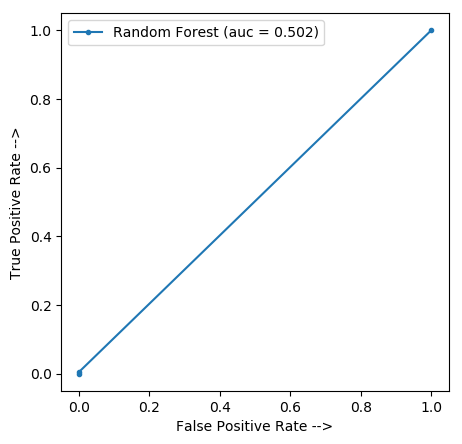

In [119]:
RF_fpr, RF_tpr, threshold = roc_curve(y_test, RF_classifier.predict(X_test))
auc_RF = auc(RF_fpr, RF_tpr)
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(RF_fpr, RF_tpr, marker='.', label='Random Forest (auc = %0.3f)' % auc_RF)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

# Logistic Regression


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


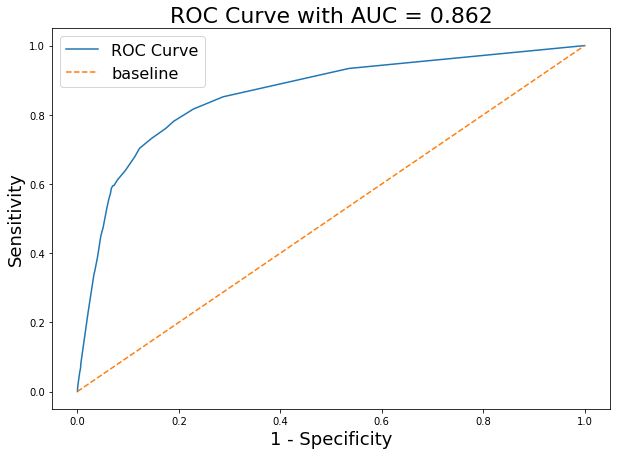

In [73]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state = 42)
# Instantiating a logisitic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)    # model fitting
y_pred = logreg.predict(X_test)   # Predictions
# Calculating class probabilities
pred_proba = [i[1] for i in logreg.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
# The codes below is motly copied from the code written by Matt Brem, Global Instructor at General Assembly.
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. 
thresholds = np.linspace(0, 1, 200)
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')
# Label axes.
plt.title(f"ROC Curve with AUC = {round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
# Create legend.
plt.legend(fontsize=16);

## We notice that the second method gave a good result because it is based on probabilities, the thing that gives more precision.


In [82]:
X_final=processed_to_predict_dataset.copy()
X_final=X_final.drop(['no_last_week','visite_fq','visite_moy','visite_rare',"duree_min","Ordinateur","os_AUTRE","Chrome","Firefox","Safari","browser_AUTRE"],axis=1)

In [83]:
y_final_pred = logreg.predict(X_final)   


In [102]:
df_final = pd.DataFrame()
df_final["identifiant"]= X_final.index
df_final["TARGET"]=y_final_pred

In [103]:
df_final.set_index('identifiant', inplace=True)

In [123]:
df_final.to_csv("Subscribers_20.txt")